In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 22 20:19:59 2023

@author: RJha
"""

import xarray as xr
import numpy as np
from pyhomogeneity import pettitt_test
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

In [2]:
ds = xr.open_dataset('/mnt/nas153/Roshan/PhD_Project_3/UVTH_Daily.nc')

uwind = ds.u.sel(level=200)
vwind = ds.v.sel(level=200)
temp = ds.t.sel(level=200)

eddy_heat = vwind * temp
mom_flux = uwind * vwind

##
R1_hw_days = xr.open_dataset('/mnt/nas153/Roshan/PhD_Project_3/Codes/Regime1_hot_days_1973_2022_NM.nc')
R2_hw_days = xr.open_dataset('/mnt/nas153/Roshan/PhD_Project_3/Codes/Regime2_hot_days_1973_2022_NM.nc')

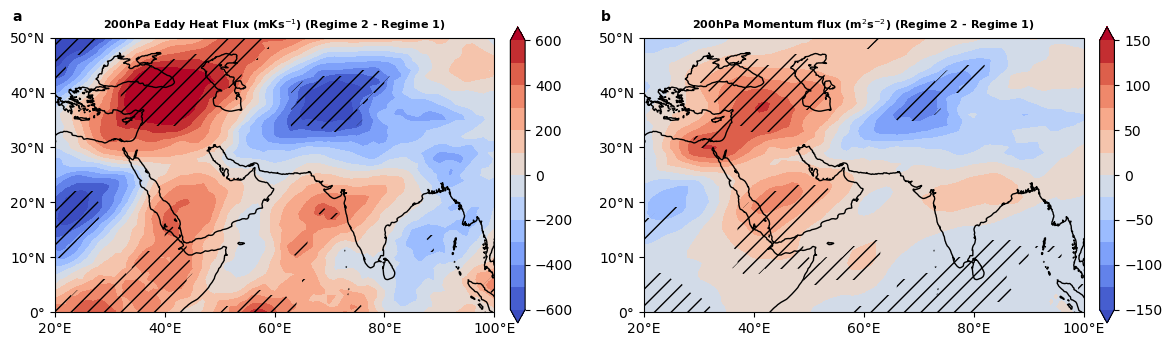

In [3]:
##################################################Difference in Regime - Eddy heat  #####################################################################
lats = eddy_heat.latitude.values
lons = eddy_heat.longitude.values
levs = eddy_heat.level.values

EH_R1 = eddy_heat.sel(time=R1_hw_days.time.values)
EH_R2 = eddy_heat.sel(time=R2_hw_days.time.values)

diff_R2_R1 = EH_R2.mean(dim=['time']) - EH_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(lats),len(lons)])
sig = np.zeros([len(lats),len(lons)])
sig[:] = np.nan

for i,lat in enumerate(lats):
    for j,lon in enumerate(lons):
        if (np.isnan(EH_R1[0,i,j])):
            result[i,j] = np.nan
        else:
            t, p = stats.ttest_ind(EH_R1[:,i,j], EH_R2[:,i,j],equal_var=False) 
            result[i,j]=t
            if p<0.05:
                sig[i,j]=1


EHF_Regime = xr.Dataset({"1973-1997": (('lat','lon'), EH_R1.mean(dim=['time']).values),
                           "1998-2022": (('lat','lon'), EH_R2.mean(dim=['time']).values),
                           "dif": (('lat','lon'), diff_R2_R1.values),
                           "sig": (('lat','lon'), sig)},
                          coords={'lat': lats, 'lon': lons})

vars = list(EHF_Regime.keys())
del vars[-2:]


##################################################Difference in Regime - Momentum flux  #####################################################################
lats = mom_flux.latitude.values
lons = mom_flux.longitude.values
levs = mom_flux.level.values

MF_R1 = mom_flux.sel(time=R1_hw_days.time.values)
MF_R2 = mom_flux.sel(time=R2_hw_days.time.values)

diff_R2_R1 = MF_R2.mean(dim=['time']) - MF_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(lats),len(lons)])
sig = np.zeros([len(lats),len(lons)])
sig[:] = np.nan


for i,lat in enumerate(lats):
    for j,lon in enumerate(lons):
        if (np.isnan(MF_R1[0,i,j])):
            result[i,j] = np.nan
        else:
            t, p = stats.ttest_ind(MF_R1[:,i,j], MF_R2[:,i,j],equal_var=False) 
            result[i,j]=t
            if p<0.05:
                sig[i,j]=1


MF_Regime = xr.Dataset({"1973-1997": (('lat','lon'), EH_R1.mean(dim=['time']).values),
                           "1998-2022": (('lat','lon'), EH_R2.mean(dim=['time']).values),
                           "dif": (('lat','lon'), diff_R2_R1.values),
                           "sig": (('lat','lon'), sig)},
                          coords={'lat': lats, 'lon': lons})

vars = list(MF_Regime.keys())
del vars[-2:]

############################################ Supplementary - Vwind Diff 200, 500 hPa and 700 hpa ##############################################################
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot2grid(shape=(1,4), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())

pvalue_mask = np.where(EHF_Regime.sig == 1, 1, np.nan)

clevs=np.arange(-600,650,100)
# Plot the trend data using contourf
diff_plot = ax1.contourf(EHF_Regime.lon, EHF_Regime.lat, EHF_Regime.dif,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

# Add a colorbar
cbar = plt.colorbar(diff_plot, orientation='vertical', pad=0.03, shrink=0.8)
#cbar.set_label('wind speed (ms$^{-1}$)',labelpad=1)

# Add hatching to the sections where p-value is 1
hatch_plot = ax1.contourf(EHF_Regime.lon, EHF_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())


# Add coastlines and gridlines
ax1.coastlines()

# Longitude labels
ax1.set_xticks(np.arange(20,105,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax1.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Crop the plot
ax1.set_extent([20, 100, 0, 50],crs=ccrs.PlateCarree())
 
# Title
ax1.set_title('200hPa Eddy Heat Flux (mKs$^{-1}$) (Regime 2 - Regime 1)',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

######

ax2 = plt.subplot2grid(shape=(1,4), loc=(0,2), colspan=2, fig=fig, projection=ccrs.PlateCarree())

pvalue_mask = np.where(MF_Regime.sig == 1, 1, np.nan)

clevs=np.arange(-150,155,25)
# Plot the trend data using contourf
diff_plot = ax2.contourf(MF_Regime.lon, MF_Regime.lat, MF_Regime.dif, clevs,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

# Add a colorbar
cbar = plt.colorbar(diff_plot, orientation='vertical', pad=0.03, shrink=0.8)
#cbar.set_label('wind speed (m$^{2}$s$^{-2}$)',labelpad=1)

# Add hatching to the sections where p-value is 1
hatch_plot = ax2.contourf(MF_Regime.lon, MF_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())


# Add coastlines and gridlines
ax2.coastlines()

# Longitude labels
ax2.set_xticks(np.arange(20,105,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax2.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax2.yaxis.set_major_formatter(lat_formatter)

# Crop the plot
ax2.set_extent([20, 100, 0, 50],crs=ccrs.PlateCarree())
 
# Title
ax2.set_title('200hPa Momentum flux (m$^{2}$s$^{-2}$) (Regime 2 - Regime 1)',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')


plt.tight_layout()
plt.savefig('SFigure_5.png', dpi=600,bbox_inches='tight')
plt.savefig('SFigure_5.pdf', dpi=600,bbox_inches='tight')
